In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

import os
from sklearn.metrics import silhouette_score
import umap

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [0]:
# !pip install pymagnitude

In [0]:
from pymagnitude import Magnitude

In [5]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data_path = os.path.join('gdrive', 'My Drive', 'Colab Notebooks', 'text_clustering', 'million-headlines', 'abcnews-date-text.csv')

In [7]:
# dataframe
df_all = pd.read_csv(data_path)

# get year from date and put that in a new column "year"
df_all['year'] = df_all['publish_date'].apply(lambda s: str(s)[:4])

print('shape of dataframe:', df_all.shape)

shape of dataframe: (1103663, 3)


In [8]:
print('number of news headlines in different years:')
print(df_all.groupby('year')['year'].count())

number of news headlines in different years:
year
2003    64003
2004    72674
2005    73124
2006    66912
2007    77192
2008    80014
2009    76454
2010    74948
2011    77829
2012    89109
2013    92337
2014    82330
2015    77941
2016    54614
2017    44182
Name: year, dtype: int64


In [9]:
# get news headlines from 2017 only
df = df_all.loc[df_all['year'] == "2017"]

print('shape of dataframe:', df.shape)

shape of dataframe: (44182, 3)


In [10]:
sentences = df['headline_text'].values
print('headlines:')
print(sentences)

headlines:
['1986 queensland cabinet documents released'
 'actor william cristopher mash chaplain dead at 84'
 'adelaide hip hop artist dreams becoming influential in australia' ...
 'what 2017 meant to the kids of australia'
 'what the papodopoulos meeting may mean for ausus'
 'who is george papadopoulos the former trump campaign aide']


In [11]:
# download glove vectors
!wget http://magnitude.plasticity.ai/glove/light/glove.6B.100d.magnitude glove/

--2019-12-21 01:42:42--  http://magnitude.plasticity.ai/glove/light/glove.6B.100d.magnitude
Resolving magnitude.plasticity.ai (magnitude.plasticity.ai)... 52.216.237.90
Connecting to magnitude.plasticity.ai (magnitude.plasticity.ai)|52.216.237.90|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 193871872 (185M) [binary/octet-stream]
Saving to: ‘glove.6B.100d.magnitude’

glove.6B.100d.magni 100%[===================>] 184.89M  49.4MB/s    in 3.8s    

2019-12-21 01:42:46 (48.6 MB/s) - ‘glove.6B.100d.magnitude’ saved [193871872/193871872]

--2019-12-21 01:42:46--  http://glove/
Resolving glove (glove)... failed: Name or service not known.
wget: unable to resolve host address ‘glove’
FINISHED --2019-12-21 01:42:46--
Total wall clock time: 4.1s
Downloaded: 1 files, 185M in 3.8s (48.6 MB/s)


In [0]:
# Load Magnitude GloVe vectors
glove_vectors = Magnitude('glove/glove.6B.100d.magnitude')

In [0]:
sentences_tok = list(map(str.split, sentences))

In [28]:
# GLOVE embeddings

sentence_embs = glove_vectors.query(sentences_tok)

# compute sentence embedding as mean of word embeddings
sentence_embs = sentence_embs.mean(1)


print(sentence_embs.shape)

(44182, 100)


In [0]:
################
# kmeans utils #
################

def forgy(X, n_clusters):
    _len = len(X)
    indices = np.random.choice(_len, n_clusters, replace=False)
    initial_state = X[indices]
    return initial_state


def do_kmeans_clustering(X, n_clusters, distance='euclidean', tol=1e-4, device=torch.device('cpu')):
    print(f'k-means clustering on {device}..')

    if distance == 'euclidean':
        pairwise_distance_function = pairwise_distance
    elif distance == 'cosine':
        pairwise_distance_function = pairwise_cosine
    else:
        raise NotImplementedError

    X = X.float()
    # transfer to device
    X = X.to(device)

    initial_state = forgy(X, n_clusters)

    iteration = 0
    tqdm_meter = tqdm()
    while True:
        dis = pairwise_distance_function(X, initial_state)

        choice_cluster = torch.argmin(dis, dim=1)

        initial_state_pre = initial_state.clone()

        for index in range(n_clusters):
            selected = torch.nonzero(choice_cluster == index).squeeze().to(device)

            selected = torch.index_select(X, 0, selected)
            initial_state[index] = selected.mean(dim=0)

        center_shift = torch.sum(torch.sqrt(torch.sum((initial_state - initial_state_pre) ** 2, dim=1)))

        # increment iteration
        iteration = iteration + 1

        # update tqdm meter
        tqdm_meter.set_postfix(iteration=f'{iteration}', center_shift=f'{center_shift ** 2}', tol=f'{tol}')

        if center_shift ** 2 < tol:
            break

    return choice_cluster.cpu(), initial_state.cpu()


def kmeans_predict(X, cluster_centers, distance='euclidean', device=torch.device('cpu')):
    print(f'predicting on {device}..')

    if distance == 'euclidean':
        pairwise_distance_function = pairwise_distance
    elif distance == 'cosine':
        pairwise_distance_function = pairwise_cosine
    else:
        raise NotImplementedError

    X = X.float()
    # transfer to device
    X = X.to(device)

    dis = pairwise_distance_function(X, cluster_centers)
    choice_cluster = torch.argmin(dis, dim=1)

    return choice_cluster.cpu()


'''
calculation of pairwise distance, and return condensed result,
 i.e. we omit the diagonal and duplicate entries and store 
 everything in a one-dimensional array
'''


def pairwise_distance(data1, data2=None, device=torch.device('cpu')):
    r'''
    using broadcast mechanism to calculate pairwise euclidean distance of data
    the input data is N*M matrix, where M is the dimension
    we first expand the N*M matrix into N*1*M matrix A and 1*N*M matrix B
    then a simple elementwise operation of A and B will handle the pairwise operation of points represented by data
    '''
    if data2 is None:
        data2 = data1

    data1, data2 = data1.to(device), data2.to(device)

    # N*1*M
    A = data1.unsqueeze(dim=1)

    # 1*N*M
    B = data2.unsqueeze(dim=0)

    dis = (A - B) ** 2.0
    # return N*N matrix for pairwise distance
    dis = dis.sum(dim=-1).squeeze()
    return dis


def pairwise_cosine(data1, data2=None, device=torch.device('cpu')):
    r'''
    using broadcast mechanism to calculate pairwise cosine distance of data
    the input data is N*M matrix, where M is the dimension
    we first expand the N*M matrix into N*1*M matrix A and 1*N*M matrix B
    then a simple elementwise operation of A and B will handle the pairwise operation of points represented by data
    '''
    if data2 is None:
        data2 = data1

    data1, data2 = data1.to(device), data2.to(device)

    # N*1*M
    A = data1.unsqueeze(dim=1)

    # 1*N*M
    B = data2.unsqueeze(dim=0)

    # normalize the points  | [0.3, 0.4] -> [0.3/sqrt(0.09 + 0.16), 0.4/sqrt(0.09 + 0.16)] = [0.3/0.5, 0.4/0.5]
    A_normalized = A / A.norm(dim=-1, keepdim=True)
    B_normalized = B / B.norm(dim=-1, keepdim=True)

    cosine = A_normalized * B_normalized

    # return N*N matrix for pairwise distance
    cosine_dis = 1 - cosine.sum(dim=-1).squeeze()
    return cosine_dis


def group_pairwise(X, groups, device=torch.device('cpu'), fun=lambda r, c: pairwise_distance(r, c).cpu()):
    group_dict = {}
    for group_index_r, group_r in enumerate(groups):
        for group_index_c, group_c in enumerate(groups):
            R, C = X[group_r], X[group_c]
            R, C = R.to(device), C.to(device)
            group_dict[(group_index_r, group_index_c)] = fun(R, C)
    return group_dict


In [0]:
# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [31]:
# find good k (number of clusters)

sil_scores = []
for k in [2, 3, 4, 5, 6]:
    # k-means clustering
    cluster_ids_x, cluster_centers = do_kmeans_clustering(
        X=torch.from_numpy(sentence_embs),
        n_clusters=k,
        distance='cosine',
        device=device
    )

    sil_scores.append(silhouette_score(sentence_embs, cluster_ids_x.numpy(), metric='cosine'))

k-means clustering on cuda:0..


0it [00:00, ?it/s, center_shift=9.998252789955586e-05, iteration=5, tol=0.0001] 
0it [00:00, ?it/s, center_shift=0.2516506016254425, iteration=1, tol=0.0001]

k-means clustering on cuda:0..


0it [00:01, ?it/s, center_shift=9.468859934713691e-05, iteration=9, tol=0.0001] 
0it [00:00, ?it/s, center_shift=0.46211981773376465, iteration=1, tol=0.0001]

k-means clustering on cuda:0..


0it [00:01, ?it/s, center_shift=7.081524381646886e-05, iteration=10, tol=0.0001]
0it [00:00, ?it/s, center_shift=0.6817715167999268, iteration=1, tol=0.0001]

k-means clustering on cuda:0..


0it [00:02, ?it/s, center_shift=6.983326602494344e-05, iteration=17, tol=0.0001]
0it [00:00, ?it/s, center_shift=0.9555698037147522, iteration=1, tol=0.0001]

k-means clustering on cuda:0..


0it [00:01, ?it/s, center_shift=5.675719876307994e-05, iteration=13, tol=0.0001] 


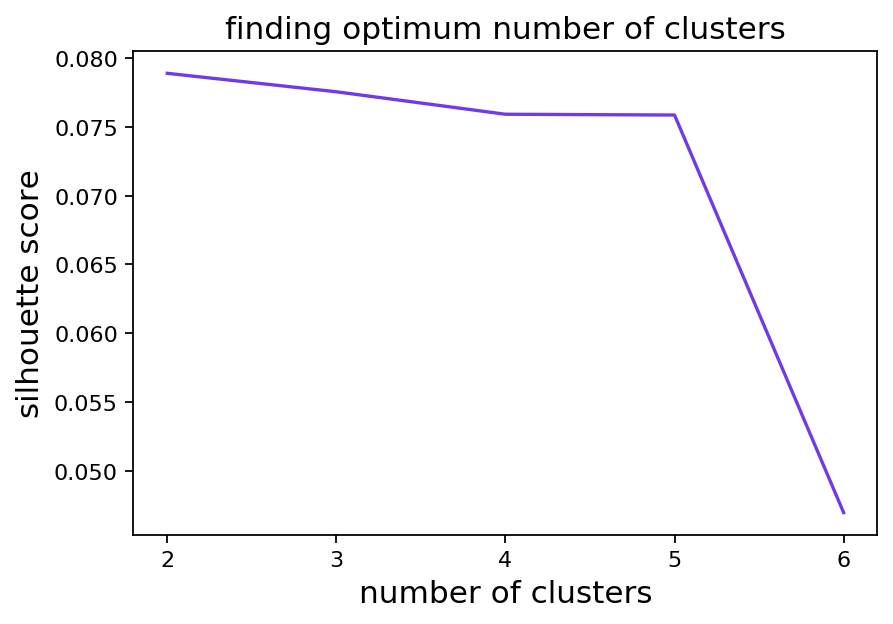

In [32]:
# plot silhouette scores
plt.figure(figsize=(6, 4), dpi=160)
plt.plot([2, 3, 4, 5, 6], sil_scores, color='xkcd:bluish purple')
plt.xticks([2, 3, 4, 5, 6])
plt.xlabel('number of clusters', fontsize=14)
plt.ylabel('silhouette score', fontsize=14)
plt.title('finding optimum number of clusters', fontsize=14)
plt.show()

In [33]:
# cluster using k with max silhoutte score
num_clusters = np.argmax(sil_scores) + 2  # 0th index means 2 clusters, ..

cluster_ids_x, cluster_centers = do_kmeans_clustering(
    X=torch.from_numpy(sentence_embs),
    n_clusters=num_clusters,
    distance='cosine',
    device=device
)

0it [00:00, ?it/s, center_shift=0.1724998652935028, iteration=1, tol=0.0001]

k-means clustering on cuda:0..


0it [00:00, ?it/s, center_shift=7.715690298937261e-05, iteration=6, tol=0.0001]


In [35]:
# UMAP
emb_umap = umap.UMAP(metric='cosine', verbose=True).fit_transform(sentence_embs)

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='cosine',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Sat Dec 21 01:55:55 2019 Finding Nearest Neighbors
Sat Dec 21 01:55:55 2019 Building RP forest with 16 trees
Sat Dec 21 01:55:57 2019 NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
Sat Dec 21 01:56:15 2019 Finished Nearest Neighbor Search
Sat Dec 21 01:56:18 2019 Construct embedding


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Dec 21 01:57:13 2019 Finished embedding


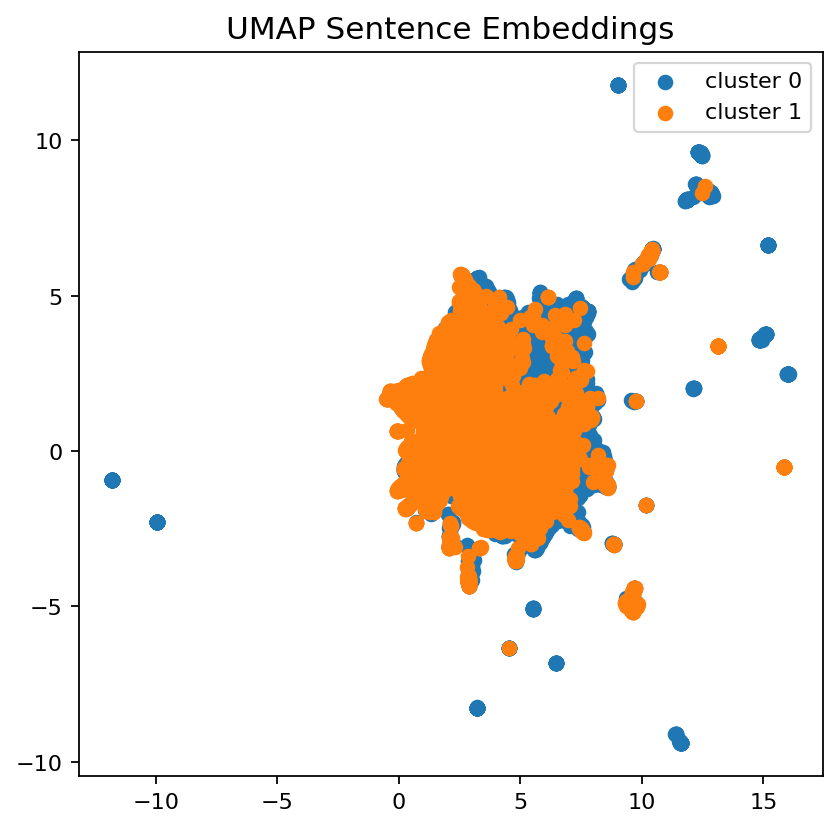

In [37]:
# plot
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
plt.figure(figsize=(6, 6), dpi=160)
for cluster_id in range(num_clusters):
    plt.scatter(
        emb_umap[cluster_ids_x == cluster_id][:, 0],
        emb_umap[cluster_ids_x == cluster_id][:, 1],
        color=cols[cluster_id],
        label=f'cluster {cluster_id}'
    )

plt.title('UMAP Sentence Embeddings', fontsize=14)
plt.legend(fontsize=10)
plt.show()

In [38]:
np.random.choice(sentences[cluster_ids_x == 0], 20, replace=False)

array(['crocodile forces closure of berry springs swmming hole in nt',
       'first time mothers uncertain about vaccinating their children',
       'forgotten stories of indigenous heritage discovered in archives',
       'rattled by trump arab leaders renew call for palestine',
       'dead carp wash up along hindmarsh island',
       'india vs australia pat cummins ready for potential test return',
       'unexpected labour handled calmly and safely by nsw ambulance',
       'lindt cafe siege new laws protect police shoot terrorists dead',
       'qld police survey results show third of officers feel burned out',
       'red bull heir continues to evade charges over',
       'why are all virtual assisants female and are they discriminatory',
       'tiwi islands catholic priest welcome same sex marriage weddings',
       'alleged adelaide killer affected by sensory deprivation',
       'three women found dead on gold coast',
       'grandstand 2017 sporting year in review',
       

In [39]:
np.random.choice(sentences[cluster_ids_x == 1], 20, replace=False)

array(['blackmores boss christine holgate china trade',
       'interview: tony burke; shadow environment and',
       'hobart cable car explained',
       'page turner an invaluable partner for omega ensemble pianists',
       'interview: faisal mekdad; syrias deputy foreign',
       'donald trump threatens the press; again',
       'russias lawyer goes off script in mh17 hague hearings',
       'superintendent mick odowd makes a public appeal',
       'aoc media director mike tancred cleared of bullying',
       'body of 79yo man recovered from murray river',
       'tractor trek traces burke and wills journey',
       'sophie cape says experimental surgeries left her scarred',
       'new zealand authorities issue arrest warrant for alan langdon',
       'queens bday honours neil mackenzie rail enthusiast brisbane',
       'rambo police pilot reappears after hijacking chopper',
       'man dies after oaklands park stabbing',
       'afl scorecentre geelong cats adelaide crows', 'mus